In [1]:
%load_ext autoreload
%autoreload 2

from pprint import pprint

import matplotlib
from matplotlib import pyplot
pyplot.ion()
pyplot.style.use('dark_background')


In [2]:
from rl.algs.pg import *

[2018-02-10 10:59:29,804] Making new env: CartPole-v1


graph(%1 : Float(1, 4)
      %2 : Float(128, 4)
      %3 : Float(128)
      %4 : Float(2, 128)
      %5 : Float(2)) {
  %8 : Float(1, 128) = Gemm[alpha=1, beta=1, broadcast=1, transB=1](%1, %2, %3), uses = [%9.i0];
  %9 : Float(1, 128) = Relu(%8), uses = [%12.i0];
  %12 : Float(1, 2) = Gemm[alpha=1, beta=1, broadcast=1, transB=1](%9, %4, %5), uses = [%13.i0];
  %13 : Float(1, 2) = Softmax[axis=1](%12), uses = [%14.i0];
  %14 : Float(1, 2) = Log(%13), uses = [%0.i0];
  return (%14);
}

Exported model to: /tmp/tmpy8qnfalm


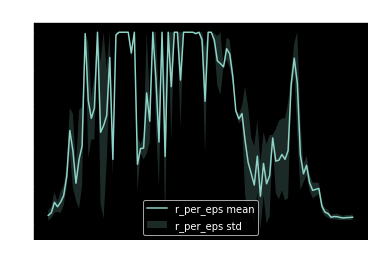

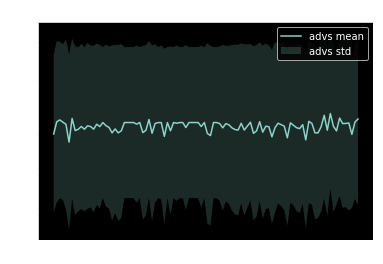

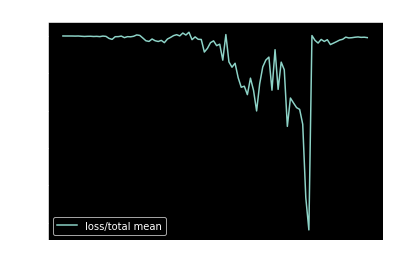

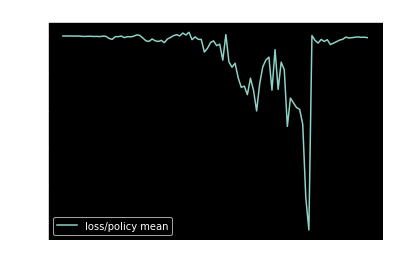

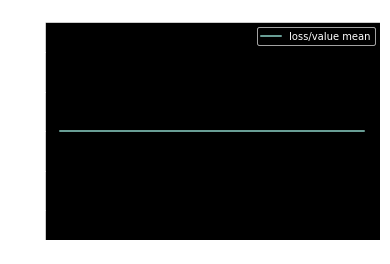

In [23]:
# Discrete task, no NN baseline
env_name = 'CartPole-v1'
train_params = TrainParams(
  num_train_iters=500,
  steps_per_batch=500,
  steps_per_snapshot=5,
  lr=0.005,
  discount=0.99,
)
model_params = {
  'hidden_layers': (128,),
}
exp = Experiment(env_name, train_params, model_params)
exps[env_name] = exp
exp.train()


In [24]:
exps['CartPole-v1'].visualize(num_episodes=5)


Step: 265. Expected reward: 500.0


[2018-02-10 11:04:16,877] Making new env: CartPole-v1


Reward: mean 500.00, std 0.00 over 5 episodes.
Actual rewards: [[500.0, 500.0, 500.0, 500.0, 500.0]]


[2018-02-11 09:59:49,143] Making new env: CartPole-v1


Exported model to: /tmp/tmprx5tzud4
Exported model to: /tmp/tmpsqp64bpc


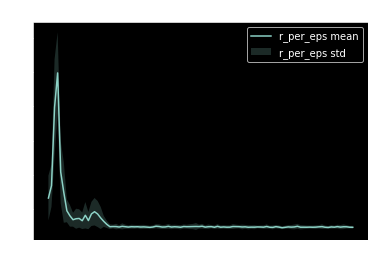

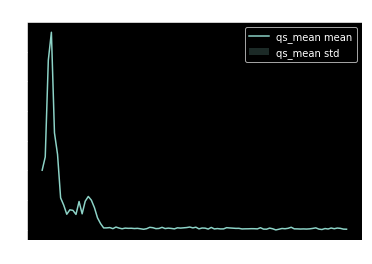

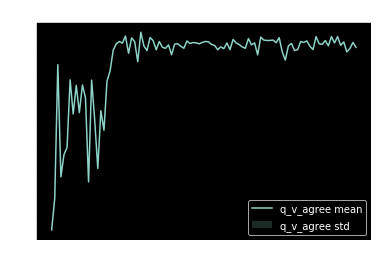

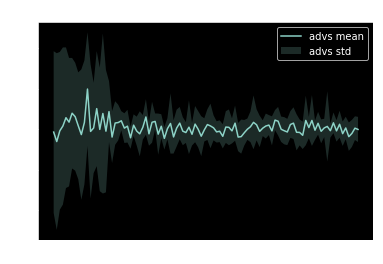

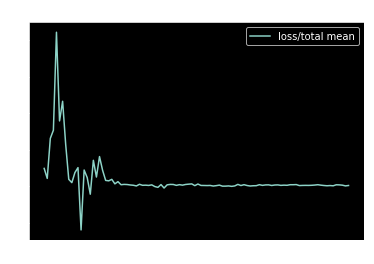

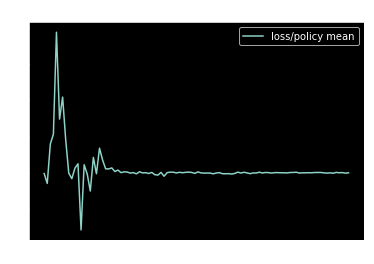

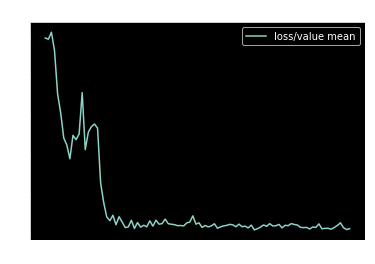

In [3]:
# Discrete task, NN baseline
env_name = 'CartPole-v1'
train_params = TrainParams(
  num_train_iters=500,
  steps_per_batch=500,
  steps_per_snapshot=5,
  lr=0.005,
  discount=0.99,
)
model_params = {
  'hidden_layers': (128,),
}
value_nn_params = {
  'hidden_layers': (128, 128,),
}
exp = Experiment(env_name, train_params, model_params, value_nn_params)
exps[env_name] = exp
exp.train()


In [11]:
exps['CartPole-v1'].visualize(num_episodes=5)

Step: 455. Expected reward: 500.0


[2018-02-07 23:12:44,471] Making new env: CartPole-v1


Reward: mean 500.00, std 0.00 over 5 episodes.
Actual rewards: [[500.0, 500.0, 500.0, 500.0, 500.0]]


[2018-02-10 20:59:24,541] Making new env: RoboschoolInvertedPendulum-v1


graph(%1 : Float(1, 5)
      %2 : Float(1, 1)
      %3 : Float(64, 5)
      %4 : Float(64)
      %5 : Float(64, 64)
      %6 : Float(64)
      %7 : Float(64, 64)
      %8 : Float(64)
      %9 : Float(64, 64)
      %10 : Float(64)
      %11 : Float(1, 64)
      %12 : Float(1)) {
  %15 : Float(1, 64) = Gemm[alpha=1, beta=1, broadcast=1, transB=1](%1, %3, %4), uses = [%16.i0];
  %16 : Float(1, 64) = Relu(%15), uses = [%19.i0];
  %19 : Float(1, 64) = Gemm[alpha=1, beta=1, broadcast=1, transB=1](%16, %5, %6), uses = [%20.i0];
  %20 : Float(1, 64) = Relu(%19), uses = [%23.i0];
  %23 : Float(1, 64) = Gemm[alpha=1, beta=1, broadcast=1, transB=1](%20, %7, %8), uses = [%24.i0];
  %24 : Float(1, 64) = Relu(%23), uses = [%27.i0];
  %27 : Float(1, 64) = Gemm[alpha=1, beta=1, broadcast=1, transB=1](%24, %9, %10), uses = [%28.i0];
  %28 : Float(1, 64) = Relu(%27), uses = [%31.i0];
  %31 : Float(1, 1) = Gemm[alpha=1, beta=1, broadcast=1, transB=1](%28, %11, %12), uses = [%0.i0];
  return (%31, %2);
}


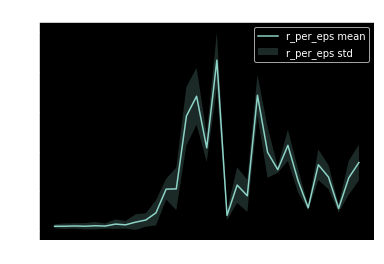

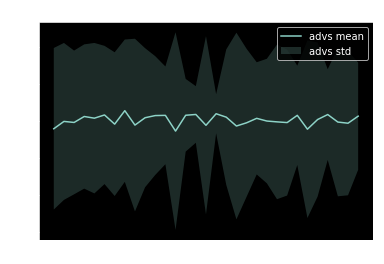

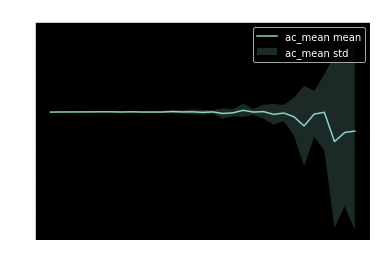

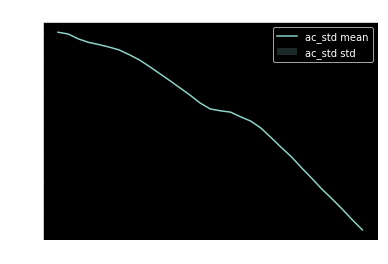

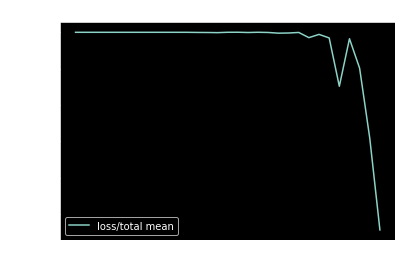

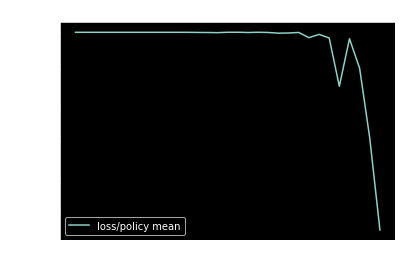

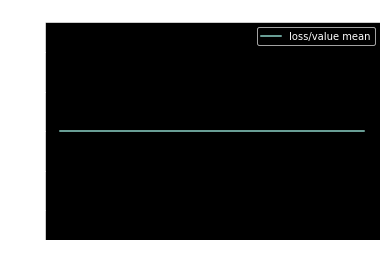

In [25]:
# Continuous task, no NN baseline.
import roboschool

env_name = 'RoboschoolInvertedPendulum-v1'
train_params = TrainParams(
  num_train_iters=151,
  steps_per_batch=1000,
  steps_per_snapshot=5,
  lr=0.001,
  discount=0.9,
)
model_params = {
  'shared_layers': (64,) * 3,
  'action_layers': (64,) * 1,
  'model_std': False,
  'min_std': None,
}
value_nn_params = {
  'hidden_layers': (4,),
}
exp = Experiment(env_name, train_params, model_params)
exps[env_name] = exp
exp.train()


In [26]:
exps['RoboschoolInvertedPendulum-v1'].visualize(num_episodes=3)


Step: 80. Expected reward: 860.0


[2018-02-10 21:45:35,409] Making new env: RoboschoolInvertedPendulum-v1


Reward: mean 337.67, std 52.60 over 3 episodes.
Actual rewards: [[303.0, 298.0, 412.0]]
